In [2]:
import pandas as pd
import numpy as np 
import glob 
import warnings 
from collections import Counter
warnings.filterwarnings("ignore")
import plotly.express as px 
import seaborn as sns 
import matplotlib.pyplot as plt 
import lightgbm as lgbm 
from sklearn.model_selection import StratifiedKFold, train_test_split
import math
import os 
import random
import torch 
import pyarrow as pa
import pyarrow.parquet as pq
import torch.nn as nn
#from transformers import AdamW
from torch.utils.data import Dataset , DataLoader
from colorama import Fore , Style
r__=Fore.RED
g__=Fore.GREEN
st__=Style.RESET_ALL

In [3]:
def wap1(row):
    denom = row.ask_size1 + row.bid_size1
    return ((row.bid_price1 * row.ask_size1 + row.ask_price1 * row.bid_size1)/denom)
    
def wap2(row):
    denom = row.ask_size2 + row.bid_size2
    return ((row.bid_price2 * row.ask_size2 + row.ask_price2 * row.bid_size2)/denom)

def log_avg_wap(row):
    return np.log((row.wap1 + row.wap2)/2)

def log_return(list_prices):
    return np.log(list_prices).diff()
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
def custom_loss(ytrue,ypred) :
    squared_residual = (ytrue-ypred)**2/ytrue
    grad = squared_residual
    hess = np.ones(len(ytrue))
    
    return grad,hess

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False
def custom_rmspe_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    residual = residual ** 2 / y_true
    residual = np.mean(residual)
    return "eval_RMSPE", math.sqrt(residual), False
def simple_volatility(series_prix):
    mx = np.max(series_prix)
    mn = np.min(series_prix)
    moy = np.mean(series_prix)
    vol = (moy-mn)/(mx-mn)
    return vol
def count_unique(series):
    return len(np.unique(series))

## 1. Importing the Data


In [4]:

train = pd.read_parquet("target_data/target_train.parquet")
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428162,126,25653,0.003977
428163,126,25654,0.001674
428164,126,25668,0.006922
428165,126,25680,0.002081


In [5]:
book_train_stock_id_0 = pd.read_parquet("stock_book_train/stock_18_train.parquet")
book_train_stock_id_0_t_id5 = book_train_stock_id_0[book_train_stock_id_0["time_id"]==5]
#book_train_stock_id_0_t_id5
book_train_stock_id_0_t_id5

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001050,1.003386,0.999703,1.003392,6,101,9,6
1,5,2,1.001050,1.003386,0.999703,1.003404,6,101,9,100
2,5,3,1.001050,1.003386,0.999703,1.003404,1,101,9,100
3,5,4,1.001050,1.003386,0.999703,1.005412,1,108,9,1
4,5,7,1.001050,1.003380,0.999703,1.003386,1,101,9,7
...,...,...,...,...,...,...,...,...,...,...
252,5,591,0.999710,1.002175,0.999703,1.002910,200,1,102,1
253,5,593,0.999716,1.002175,0.999710,1.002910,100,1,100,1
254,5,594,0.999716,1.002175,0.999710,1.002910,100,1,100,1
255,5,596,0.999716,1.002175,0.999710,1.002910,200,1,100,1


In [6]:
trade_train_stock_id_0 = pd.read_parquet("stock_trade_train/stock_18_train.parquet")
trade_train_stock_id_0

,time_id,seconds_in_bucket,price,size,order_count
0,5,19,1.003380,108,4
1,5,48,1.004457,103,2
2,5,68,1.005555,6,2
3,5,81,1.004535,2,1
4,5,89,1.006018,100,2
...,...,...,...,...,...
68668,25683,589,0.958922,18,4
68669,25683,592,0.960054,419,8
68670,25683,593,0.958775,14,2
68671,25683,596,0.957868,107,2


In [7]:
trade_train_stock_id_0.groupby(['time_id']).mean().reset_index().iloc[1013:1015,]

,time_id,seconds_in_bucket,price,size,order_count
1013,8518,284.266667,0.996877,167.600000,4.800000
1014,8534,309.578947,0.999614,49.263158,2.473684


## 2 i) Feature Engineering (TRADE DATA)


In [8]:
#Feature 1 -> Relative volume by 10min bucket

#1. Finding average size (volume) across all time_id's

avg_trade_volume_stock_id_0 = trade_train_stock_id_0.groupby(['time_id']).sum()["size"].mean() #this groups by time id, gets the total sum of the size, then it gets the mean across all time buckets 
 
#2. Get size (volume) of time_id = 5
trade_volume_stock_id_0_time_id_5 = trade_train_stock_id_0[trade_train_stock_id_0['time_id'] == 5]["size"].sum() #gives me the volume of time bucket 5

#3. Compute relative volume
rel_trade_volume_stock_id_0_time_id_5 = trade_volume_stock_id_0_time_id_5/avg_trade_volume_stock_id_0
rel_trade_volume_stock_id_0_time_id_5

1.102409415389476

In [22]:
avg_trade_volume_stock_id_0

1867.7271540469974

In [25]:
trade_train_stock_id_0['time_id'].mean()

12615.123920609265

In [14]:
#Feature 2 -> Relative price range 

#1. Find min and max of trade price for all seperate time_id. 
min_trade_price_stock_id_0 = trade_train_stock_id_0.groupby(['time_id']).min()
max_trade_price_stock_id_0 = trade_train_stock_id_0.groupby(['time_id']).max()
#2. Find range of trade price and median of trade price for all seperate time_id. 
range_trade_price_stock_id_0 = max_trade_price_stock_id_0 - min_trade_price_stock_id_0 
median_trade_price_stock_id_0 = trade_train_stock_id_0.groupby(['time_id']).median()
#3. Use median to compute how much percent below our minimum is for all seperate time_id. 
lower_percent_range_relative_to_median = (median_trade_price_stock_id_0 - min_trade_price_stock_id_0)/median_trade_price_stock_id_0
#4. Use median to compute how much percent above our maximum is for all seperate time_id. 
upper_percent_range_relative_to_median = (max_trade_price_stock_id_0 - median_trade_price_stock_id_0)/median_trade_price_stock_id_0
#5 Add both values to get total percent range. E.g. 3% below median and 5% above median = 8% total range for all seperate time_id.
total_percent_range = upper_percent_range_relative_to_median + lower_percent_range_relative_to_median

#6. Compute the average percent range across all time id's

avg_total_percent_range = total_percent_range["price"].mean()

#7. Get total percent range for time id 5
min_price_stock_id_0_time_id_5 = trade_train_stock_id_0[trade_train_stock_id_0['time_id'] == 5]["price"].min()
max_price_stock_id_0_time_id_5 = trade_train_stock_id_0[trade_train_stock_id_0['time_id'] == 5]["price"].max()

range_stock_id_0_time_id_5 = max_price_stock_id_0_time_id_5 - min_price_stock_id_0_time_id_5 #gives me the range of price for time bucket 5
median_stock_id_0_time_id_5 = trade_train_stock_id_0[trade_train_stock_id_0['time_id'] == 5]["price"].median()

lower_percent_range_relative_to_median_stock_id_0_time_id_5 = (median_stock_id_0_time_id_5 - min_price_stock_id_0_time_id_5)/median_stock_id_0_time_id_5

upper_percent_range_relative_to_median_stock_id_0_time_id_5= (max_price_stock_id_0_time_id_5 - median_stock_id_0_time_id_5)/median_stock_id_0_time_id_5

total_percent_range_stock_id_0_time_id_5 = lower_percent_range_relative_to_median_stock_id_0_time_id_5 + upper_percent_range_relative_to_median_stock_id_0_time_id_5

#8. Compute relative percent trading range to average
rel_total_percent_range_stock_id_0_time_id_5 = total_percent_range_stock_id_0_time_id_5/avg_total_percent_range
rel_total_percent_range_stock_id_0_time_id_5

1.3810679

In [18]:
total_percent_range

,seconds_in_bucket,price,size,order_count
time_id,,,,
5,2.157480,0.007654,38.684211,8.500000
11,1.474747,0.001707,93.200000,7.000000
16,1.830000,0.002021,9.647059,5.600000
31,1.951904,0.003026,59.750000,2.666667
62,1.657658,0.002973,28.545455,3.000000
...,...,...,...,...
25653,3.182857,0.002019,6.225352,9.000000
25654,1.734426,0.001305,154.500000,13.333333
25668,2.497908,0.007704,10.163265,36.666667


In [17]:
avg_total_percent_range

0.005542023

In [15]:
total_percent_range

,seconds_in_bucket,price,size,order_count
time_id,,,,
5,2.157480,0.007654,38.684211,8.500000
11,1.474747,0.001707,93.200000,7.000000
16,1.830000,0.002021,9.647059,5.600000
31,1.951904,0.003026,59.750000,2.666667
62,1.657658,0.002973,28.545455,3.000000
...,...,...,...,...
25653,3.182857,0.002019,6.225352,9.000000
25654,1.734426,0.001305,154.500000,13.333333
25668,2.497908,0.007704,10.163265,36.666667


In [10]:
#Feature 3 -> size_per_order
size = 
size_per_order = trade_train_stock_id_0.groupby(['time_id']).sum()['order_count']
order_count

,seconds_in_bucket,price,size,order_count
time_id,,,,
5,7848.0,27.105457,2059,83
11,3245.0,11.989954,386,28
16,3674.0,18.029690,1620,76
31,3665.0,13.988105,541,47
62,5152.0,16.986509,1319,45
...,...,...,...,...
25653,4474.0,19.994778,1216,52
25654,6763.0,20.009623,540,67
25668,7541.0,24.900990,2427,325


In [9]:
#Feature 3 -> Time between execution --> size/second 

## 2 ii) Feature Engineering (BOOK DATA)


In [56]:
###Feature Engineering for ORDER BOOK data a###
book_train_stock_id_0.groupby(['time_id']).mean()

,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,avg_wap,spread_ratio_1,spread_ratio_2,vol_imbalance,log_return
time_id,,,,,,,,,,,,,,,,
5,294.215947,1.003320,1.004175,1.003144,1.004326,78.514950,74.076412,81.142857,89.737542,1.003733,1.003668,1.003701,1.000852,1.001178,10.210541,0.000008
11,332.590000,1.000011,1.000406,0.999870,1.000541,149.965000,71.145000,95.445000,94.895000,1.000239,1.000206,1.000222,1.000394,1.000671,1.303403,-0.000016
16,253.712766,0.999204,0.999929,0.999007,1.000127,96.132979,131.037234,114.526596,74.654255,0.999542,0.999680,0.999611,1.000725,1.001121,2.440987,-0.000014
31,268.791667,0.998445,0.999304,0.998255,0.999413,114.458333,120.800000,68.783333,131.225000,0.998832,0.998633,0.998732,1.000861,1.001160,2.360404,-0.000001
62,292.909091,0.999407,0.999804,0.999216,0.999913,119.823864,88.477273,87.840909,47.079545,0.999619,0.999626,0.999623,1.000397,1.000697,1.840490,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25653,334.255639,0.998724,0.999497,0.998610,0.999707,63.067669,126.180451,28.278195,96.045113,0.998950,0.998867,0.998909,1.000774,1.001098,39.953396,-0.000023
25654,291.412935,1.001351,1.001822,1.001223,1.002018,243.044776,66.860697,159.457711,72.313433,1.001690,1.001768,1.001729,1.000471,1.000795,0.561149,0.000024
25668,315.901899,0.996259,0.996981,0.996093,0.997210,66.433544,86.743671,53.768987,73.598101,0.996602,0.996550,0.996576,1.000725,1.001121,21.204706,-0.000025


In [11]:
# Compute the first weighted averaged price for each seconds_in_bucket and time ID
 
#book_train_stock_id_0["wap1"] = book_train_stock_id_0.apply(wap1,axis=1)
denom1 = book_train_stock_id_0["ask_size1"] + book_train_stock_id_0["bid_size1"]
volprice1 = book_train_stock_id_0["bid_price1"] * book_train_stock_id_0["ask_size1"] + book_train_stock_id_0["ask_price1"] * book_train_stock_id_0["bid_size1"]
book_train_stock_id_0["wap1"] = volprice1/denom1

In [12]:
# Compute the second weighted averaged price for each seconds_in_bucket and time ID 

#book_train_stock_id_0.loc[:, "wap2"] = book_train_stock_id_0.apply(wap2,axis=1)
denom2 = book_train_stock_id_0["ask_size2"] + book_train_stock_id_0["bid_size2"]
volprice2 = book_train_stock_id_0["bid_price2"] * book_train_stock_id_0["ask_size2"] + book_train_stock_id_0["ask_price2"] * book_train_stock_id_0["bid_size2"]
book_train_stock_id_0["wap2"] = volprice2/denom2

In [13]:
# Compute the avg weighted price using both wap1 and wap2 for each seconds_in_bucket and time ID 

#book_train_stock_id_0.loc[:, "log_avg_wap"] = book_train_stock_id_0.apply(log_avg_wap,axis=1)
book_train_stock_id_0["avg_wap"] = (book_train_stock_id_0["wap1"] + book_train_stock_id_0["wap2"])/2

In [14]:
#Theory, the bigger the spread the higher the volatility!!!
#Getting spread ratio's of 1 and 2
spread_ratio_1 = book_train_stock_id_0["ask_price1"]/book_train_stock_id_0["bid_price1"]
book_train_stock_id_0["spread_ratio_1"] = spread_ratio_1
spread_ratio_2 = book_train_stock_id_0["ask_price2"]/book_train_stock_id_0["bid_price2"]
book_train_stock_id_0["spread_ratio_2"] = spread_ratio_2

In [15]:
#Compute volume imbalance as an average ratio (supply/demand) per time_id
total_bid_size = book_train_stock_id_0["bid_size1"] + book_train_stock_id_0["bid_size2"]
total_ask_size = book_train_stock_id_0["ask_size1"] + book_train_stock_id_0["ask_size2"]
book_train_stock_id_0["vol_imbalance"] = total_ask_size/total_bid_size
#Finding the average volume imbalance by time_id
vol_imbalance = book_train_stock_id_0.groupby(['time_id']).mean()["vol_imbalance"]
book_train_stock_id_0.groupby(['time_id']).mean()

#how much it deviates from a ratio of 1:1 means its more significant a ratio of 10 is the same significance as a ratio of 0.1? So maybe we standardize it and say if ratio <1 do 1/ratio... so ratios like 0.1 can be changed to 10!!!


,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,avg_wap,spread_ratio_1,spread_ratio_2,vol_imbalance
time_id,,,,,,,,,,,,,,,
5,293.241722,1.003314,1.004169,1.003139,1.004320,78.264901,74.579470,80.880795,89.771523,1.003725,1.003661,1.003693,1.000852,1.001178,10.392625
11,332.590000,1.000011,1.000406,0.999870,1.000541,149.965000,71.145000,95.445000,94.895000,1.000239,1.000206,1.000222,1.000394,1.000671,1.303403
16,253.712766,0.999204,0.999929,0.999007,1.000127,96.132979,131.037234,114.526596,74.654255,0.999542,0.999680,0.999611,1.000725,1.001121,2.440987
31,268.791667,0.998445,0.999304,0.998255,0.999413,114.458333,120.800000,68.783333,131.225000,0.998832,0.998633,0.998732,1.000861,1.001160,2.360404
62,292.909091,0.999407,0.999804,0.999216,0.999913,119.823864,88.477273,87.840909,47.079545,0.999619,0.999626,0.999623,1.000397,1.000697,1.840490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25653,334.255639,0.998724,0.999497,0.998610,0.999707,63.067669,126.180451,28.278195,96.045113,0.998950,0.998867,0.998909,1.000774,1.001098,39.953396
25654,291.412935,1.001351,1.001822,1.001223,1.002018,243.044776,66.860697,159.457711,72.313433,1.001690,1.001768,1.001729,1.000471,1.000795,0.561149
25668,315.901899,0.996259,0.996981,0.996093,0.997210,66.433544,86.743671,53.768987,73.598101,0.996602,0.996550,0.996576,1.000725,1.001121,21.204706


## 3 Data Exploration (e.g. correlation)


In [16]:
#Exploring previous realized vol against target next 10 min for stock id 0
target_train = pd.read_parquet("target_data/target_train.parquet")
target_train_stock_id_0 = target_train[target_train["stock_id"] == 0]
target_train_stock_id_0

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
3060,0,25653,0.002747
3061,0,25654,0.002667
3062,0,25668,0.004750
3063,0,25680,0.001235


In [17]:
#get the log returns for stock 0 using avg_wap
book_train_stock_id_0.loc[:, 'log_return'] = log_return(book_train_stock_id_0["avg_wap"])
#just extract all rows that aren't null...
book_train_stock_id_0 = book_train_stock_id_0[~book_train_stock_id_0['log_return'].isnull()]
#examine time ID 5 by itself
book_train_stock_id_0_time_id_5 = book_train_stock_id_0[book_train_stock_id_0['time_id']==5]
book_train_stock_id_0_time_id_5

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,avg_wap,spread_ratio_1,spread_ratio_2,vol_imbalance,log_return
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.001448,1.001390,1.001419,1.000878,1.000981,40.000000,7.034724e-06
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,1.001419,1.000878,1.001033,40.000000,5.065051e-07
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,1.001417,1.000878,1.001033,45.200000,-2.576881e-06
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,1.001417,1.000878,1.001033,45.200000,0.000000e+00
5,5,11,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,1.001419,1.000878,1.001033,40.000000,2.576881e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,1.003726,1.000619,1.000773,0.047619,4.482279e-04
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,1.003409,1.000619,1.001186,0.058824,-3.155930e-04
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,1.003731,1.003721,1.003726,1.000619,1.000773,0.047619,3.155930e-04
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,1.003731,1.003087,1.003409,1.000619,1.001186,0.058824,-3.155930e-04


In [18]:
#Plotting log returns for stock 0
fig = px.line(book_train_stock_id_0_time_id_5, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
fig.show()

In [19]:
#Calculating realized volatility for stock0, time_id 5 
realized_vol = realized_volatility(book_train_stock_id_0_time_id_5['log_return'])
realized_vol

0.0041146791172599435

In [20]:
#Is previous 10min volatility related to next 10 min vol???!!!
realized_vol_id_0 = book_train_stock_id_0.groupby("time_id")["log_return"].apply(realized_volatility) #going through book data of stock 0, grouping by time_id and getting realized volatility using log returns
realized_vol_id_0
vol_id_0_df = pd.DataFrame(columns=[target_train_stock_id_0["target"], realized_vol_id_0])
realized_vol_id_0
#target_train_stock_id_0["target"]
vol_id_0_df = vol_id_0_df.T
vol_id_0_df
vol_id_0_df.reset_index(inplace=True)
vol_id_0_df = vol_id_0_df.rename(columns={"target": "Target Volatility", "log_return": "Realized Volatility"})
vol_id_0_df

,Target Volatility,Realized Volatility
0,0.004136,0.004115
1,0.001445,0.004048
2,0.002168,0.002876
3,0.002195,0.003486
4,0.001747,0.003098
...,...,...
3060,0.002747,0.002566
3061,0.002667,0.003456
3062,0.004750,0.007960
3063,0.001235,0.004866


In [21]:
fig = px.scatter(vol_id_0_df, x='Realized Volatility', y='Target Volatility', title='Target Volatility vs Realized Volatility Last 10 min')
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=20)
fig.update_layout(xaxis_range=[0, 0.03])

fig.show()

In [22]:
vol_id_0_df.corr()
#It appears that we have a strong positive correlation between realized volatility and target volatility of the prev 10 min? Is this random? Lets check the other 10 min intervals!!!!!
#WAP_AVG to calculate realized vol of first 10 mins
#WAP1 might be better? 

,Target Volatility,Realized Volatility
Target Volatility,1.000000,0.608736
Realized Volatility,0.608736,1.000000


In [23]:
#Conduct a quick random algorithm to show that only the current time_id's was related to the next 10 mins (i.e. target volatility), and previous time_id's had no effect on later time_id's... 

#Use sample function to shift around target volatility data randomly
vol_id_0_df_shifted = vol_id_0_df.copy()
vol_id_0_df_shifted["Target Volatility"] = vol_id_0_df_shifted["Target Volatility"].sample(frac=1).reset_index(drop=True)
#np.random.uniform(low=0, high=)
vol_id_0_df_shifted

,Target Volatility,Realized Volatility
0,0.003116,0.004115
1,0.003175,0.004048
2,0.001898,0.002876
3,0.006168,0.003486
4,0.005284,0.003098
...,...,...
3060,0.002932,0.002566
3061,0.002503,0.003456
3062,0.002784,0.007960
3063,0.001350,0.004866


In [117]:
global test
global correlation_dict
correlation_dict = {
    "stock_id": [],
    "realized_t_corr": [],
    "realized_t_1_corr": [],
    "realized_t_2_corr": [],
    "realized_t_3_corr": [],
    "realized_t_4_corr": [],
    "realized_t_5_corr": [],

}
def isValidStock(i):
    filename = "stock_trade_train/stock_" + str(i) + "_train.parquet"
    print(filename)
    if not os.path.exists(filename):
        return False
    return True
global tester 
def corrHeatmap(subset):
    global correlation_dict
    for j in range(127):
        if not isValidStock(j):
            continue

        #generalizing an algorithm for all stocks to create average correlation matrix... 
        #Begin by reading in the target train data for every stock... 
        parquet_path = "stock_book_train/stock_" + str(j) + "_train.parquet"
        book_train_stock_id_j = pd.read_parquet(parquet_path)
        
        target_train = pd.read_parquet("target_data/target_train.parquet")
        #Filter out the stock we are interested in
        target_train_stock_id_j = target_train[target_train["stock_id"] == j]

        #getting wap
        # Compute the first weighted averaged price for each seconds_in_bucket and time ID 
        denom1 = book_train_stock_id_j["ask_size1"] + book_train_stock_id_j["bid_size1"]
        volprice1 = book_train_stock_id_j["bid_price1"] * book_train_stock_id_j["ask_size1"] + book_train_stock_id_j["ask_price1"] * book_train_stock_id_j["bid_size1"]
        book_train_stock_id_j["wap1"] = volprice1/denom1

        # Compute the second weighted averaged price for each seconds_in_bucket and time ID 

        denom2 = book_train_stock_id_j["ask_size2"] + book_train_stock_id_j["bid_size2"]
        volprice2 = book_train_stock_id_j["bid_price2"] * book_train_stock_id_j["ask_size2"] + book_train_stock_id_j["ask_price2"] * book_train_stock_id_j["bid_size2"]
        
        book_train_stock_id_j["wap2"] = volprice2/denom2
        book_train_stock_id_j["avg_wap"] = (book_train_stock_id_j["wap1"] + book_train_stock_id_j["wap2"])/2

        #get the log returns for stock 0 using avg_wap
        book_train_stock_id_j.loc[:, 'log_return'] = log_return(book_train_stock_id_j["avg_wap"])
        #just extract all rows that aren't null...
        test = book_train_stock_id_j
        book_train_stock_id_j = book_train_stock_id_j[~book_train_stock_id_j['log_return'].isnull()]
        
        #Is previous 10min volatility related to next 10 min vol???!!!
        book_train_stock_id_j = book_train_stock_id_j[book_train_stock_id_j["seconds_in_bucket"] >= subset] #Only consider seconds_in_bucket > subset 
        
        realized_vol_id_j = book_train_stock_id_j.groupby("time_id")["log_return"].apply(realized_volatility) #going through book data of stock 0, grouping by time_id and getting realized volatility using log returns-

        vol_id_j_df = pd.DataFrame(columns=[target_train_stock_id_j["target"], realized_vol_id_j]) #create a dataframe with target data and realized volatility for each time id
        vol_id_j_df = vol_id_j_df.T
        vol_id_j_df.reset_index(inplace=True)
        vol_id_j_df = vol_id_j_df.rename(columns={"target": "Target Volatility", "log_return": "Realized Volatility"})
        vol_id_j_df


        #get correlation of realized volatility of current time id with subsequent 10 min target volatility.  
        realized_t_corr = vol_id_j_df.corr().iloc[0,1]
        correlation_dict["realized_t_corr"].append(realized_t_corr)


        #Creating a copy of realized-volatiliy~target so we can forward shift 5 times and get the new correlation of every shift...
        vol_id_j_df_shifted = vol_id_j_df.copy()
        #print(j)
        for i in range(1,6):
            realized_t_i_corr = "realized_t_" + str(i) + "_corr"
            vol_id_j_df_shifted["Realized Volatility"] = vol_id_j_df_shifted["Realized Volatility"].shift(1)
            realized_t_i_corr_value = vol_id_j_df_shifted.corr().iloc[0,1]
            correlation_dict[realized_t_i_corr].append(realized_t_i_corr_value)

        correlation_dict["stock_id"].append(j)

corrHeatmap(0)

stock_trade_train/stock_0_train.parquet
stock_trade_train/stock_1_train.parquet
stock_trade_train/stock_2_train.parquet
stock_trade_train/stock_3_train.parquet
stock_trade_train/stock_4_train.parquet
stock_trade_train/stock_5_train.parquet
stock_trade_train/stock_6_train.parquet
stock_trade_train/stock_7_train.parquet
stock_trade_train/stock_8_train.parquet
stock_trade_train/stock_9_train.parquet
stock_trade_train/stock_10_train.parquet
stock_trade_train/stock_11_train.parquet
stock_trade_train/stock_12_train.parquet
stock_trade_train/stock_13_train.parquet
stock_trade_train/stock_14_train.parquet
stock_trade_train/stock_15_train.parquet
stock_trade_train/stock_16_train.parquet
stock_trade_train/stock_17_train.parquet
stock_trade_train/stock_18_train.parquet
stock_trade_train/stock_19_train.parquet
stock_trade_train/stock_20_train.parquet
stock_trade_train/stock_21_train.parquet
stock_trade_train/stock_22_train.parquet
stock_trade_train/stock_23_train.parquet
stock_trade_train/stock_24

In [118]:
global correlation_dict
average_correlation = {key: np.mean(value) for key,value in correlation_dict.items()}
average_correlation = pd.DataFrame(list(average_correlation.items()))
average_correlation = average_correlation.drop([0], axis=0)
col_names = average_correlation.iloc[:, 0]
average_correlation = average_correlation.drop([0], axis=1)
average_correlation.columns = ['Target']
average_correlation = average_correlation.set_index(col_names)
average_correlation.index.name = None


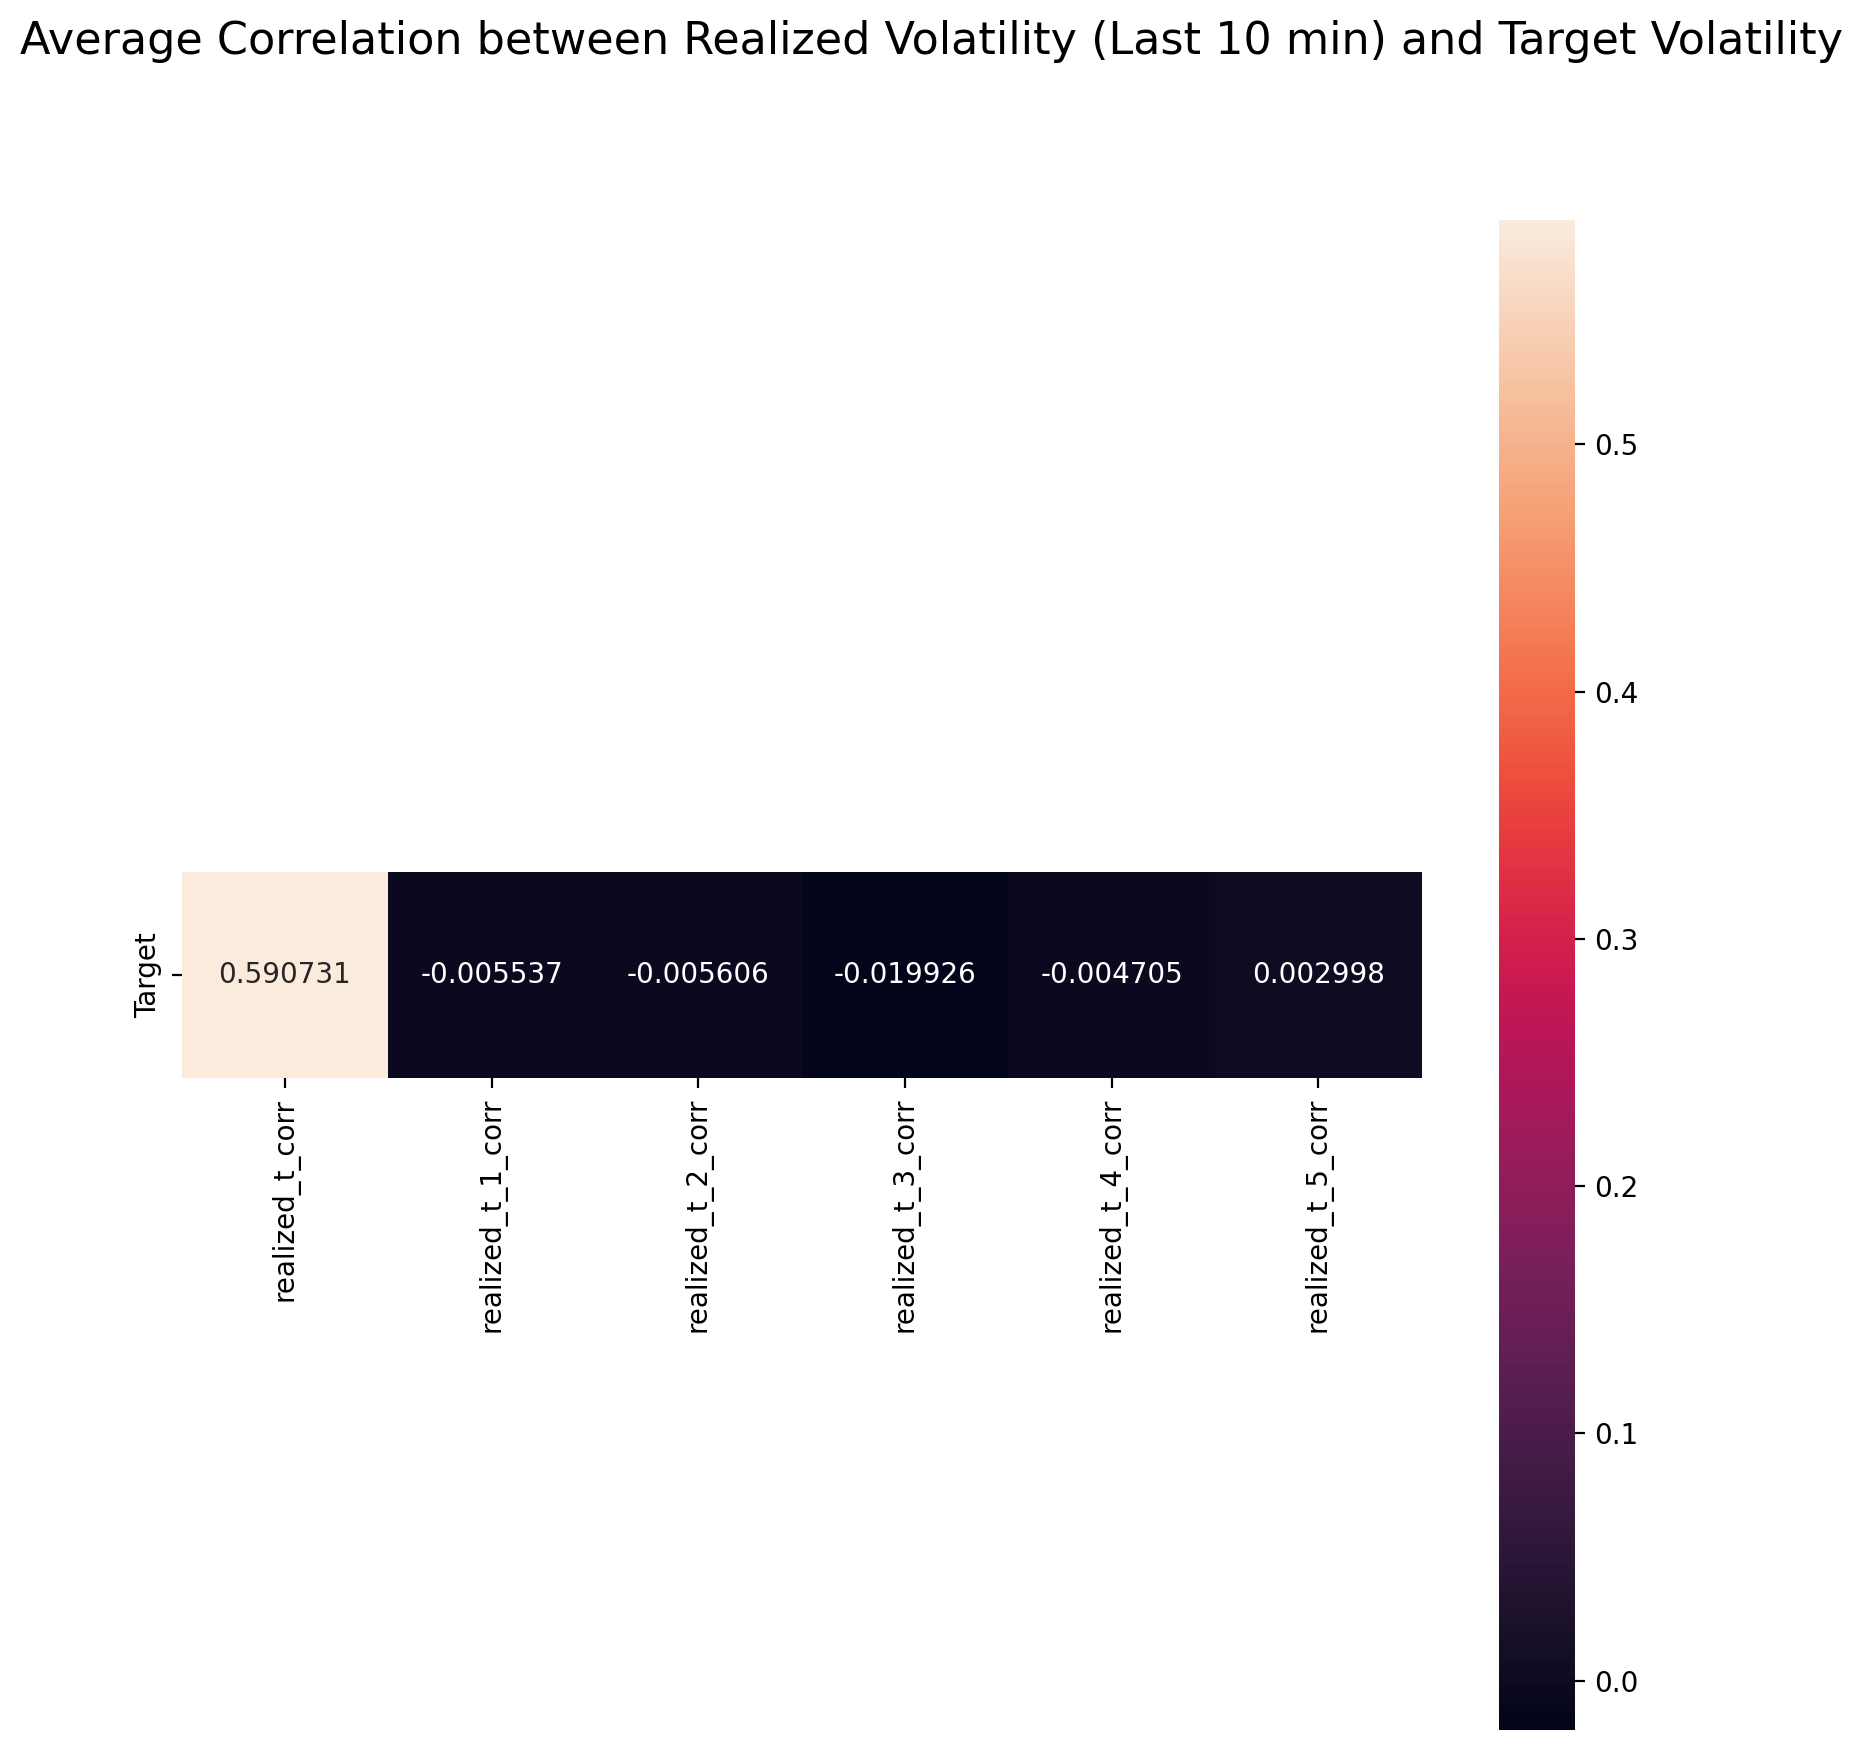

In [120]:

fig = plt.figure(figsize=(10,10), dpi=200)
sns.heatmap(data=average_correlation.T,annot=True,square=True, fmt='f')
#ax.invert_yaxis()
fig.suptitle('Average Correlation between Realized Volatility (Last 10 min) and Target Volatility', fontsize=16)
plt.show()


In [50]:
def wap(df):
        return (df['bid_price1'] * df['ask_size1'] +
                df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])

def wap2(df):
    return (df['bid_price2'] * df['ask_size2'] +
            df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(returns):
    return np.sqrt(np.sum(returns ** 2))

def count_unique(series):
    return len(np.unique(series))

def isValidStock(i):
    filename = "stock_trade_train/stock_" + str(i) + "_train.parquet"
    print(filename)
    if not os.path.exists(filename):
        return False
    return True

In [88]:
def book_predictors(stock_id, train_or_test):
    stock_data = pd.read_parquet('stock_book_' + train_or_test + '/stock_' + str(stock_id) + '_' + train_or_test + '.parquet')
    stock_data = stock_data[stock_data["seconds_in_bucket"] >= 300] 
    stock_data['avg_wap']= (wap(stock_data)+ wap2(stock_data))/2
    stock_data['log_return'] = stock_data.groupby('time_id')['avg_wap'].apply(log_return)

    create_feature_dict = {
            'log_return':[realized_volatility],
    }

    result = pd.DataFrame(stock_data.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    result.columns = result.columns.map('_'.join).str.strip('_')
    return result


def target(stock_id, train_or_test):
    result = pd.read_parquet('target_data/target_' + train_or_test + '.parquet')
    result = result.loc[result['stock_id'] == stock_id]
    result = result.drop(['stock_id'], axis = 1)
    return result

def generate_data(stock_id, train_or_test):
    result = pd.merge(target(stock_id, train_or_test), book_predictors(stock_id, train_or_test), on='time_id', how='left')
    return result

def generate_train_and_test(stock_id):
    train = generate_data(stock_id, 'train')
    test = generate_data(stock_id, 'test')

    X_train = train.drop(['target', 'time_id'], axis = 1)
    X_test = test.drop(['target', 'time_id'], axis = 1)

    y_train = train['target']
    y_test = test['target']

    return X_train, X_test, y_train, y_test

In [111]:
def mspe(y_true, y_pred):
    return  (np.mean(np.square((y_true - y_pred) / y_true)))

from sklearn.linear_model import LinearRegression
total_size = 0
total = 0
score_list = []

for i in range(127):
    if not isValidStock(i):
        continue

    #print(i)

    X_train, X_test, y_train, y_test = generate_train_and_test(i)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    total += mspe(y_test, y_pred) * X_test.shape[0]
    total_size += X_test.shape[0]
    R_2 = reg.score(X_train, y_train)
    score_list.append(R_2)



total_RMSPE = np.sqrt(total / total_size)
total_RMSPE
    




stock_trade_train/stock_0_train.parquet
stock_trade_train/stock_1_train.parquet
stock_trade_train/stock_2_train.parquet
stock_trade_train/stock_3_train.parquet
stock_trade_train/stock_4_train.parquet
stock_trade_train/stock_5_train.parquet
stock_trade_train/stock_6_train.parquet
stock_trade_train/stock_7_train.parquet
stock_trade_train/stock_8_train.parquet
stock_trade_train/stock_9_train.parquet
stock_trade_train/stock_10_train.parquet
stock_trade_train/stock_11_train.parquet
stock_trade_train/stock_12_train.parquet
stock_trade_train/stock_13_train.parquet
stock_trade_train/stock_14_train.parquet
stock_trade_train/stock_15_train.parquet
stock_trade_train/stock_16_train.parquet
stock_trade_train/stock_17_train.parquet
stock_trade_train/stock_18_train.parquet
stock_trade_train/stock_19_train.parquet
stock_trade_train/stock_20_train.parquet
stock_trade_train/stock_21_train.parquet
stock_trade_train/stock_22_train.parquet
stock_trade_train/stock_23_train.parquet
stock_trade_train/stock_24

0.331087134403389

In [113]:
X_train, X_test, y_train, y_test = generate_train_and_test(1)
X_train
#X_train[X_train.isna().any(axis=1)]

,log_return_realized_volatility
0,0.003647
1,0.001314
2,0.002070
3,0.001761
4,0.002314
...,...
3060,0.002318
3061,0.001210
3062,0.003810
3063,0.000703


In [114]:
R2 = np.mean(score_list)

In [116]:
print(f'Performance of the naive prediction: R2 score: {round(R2,2)}, RMSPE: {round(total_RMSPE,2)}')

Performance of the naive prediction: R2 score: 0.75, RMSPE: 0.33


In [ ]:
fig = px.scatter(vol_id_0_df_shifted, x='Realized Volatility', y='Target Volatility', title='Target Volatility randomized vs Realized Volatility Last 10 min')
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=20)
fig.update_layout(xaxis_range=[0, 0.03])

fig.show()

In [ ]:
vol_id_0_df_shifted.corr().iloc[0,1]

-0.033637420649341755

In [ ]:
vol_id_0_df_shifted = vol_id_0_df.copy()
vol_id_0_df_shifted["Realized Volatility"] = vol_id_0_df_shifted["Realized Volatility"].shift(1)
vol_id_0_df_shifted.corr()
#Clearly future time series data has no correlation with previous time series data... Only the prveious 10 min and next 10 min are correlaated. Past data has no effect on future 

,Target Volatility,Realized Volatility
Target Volatility,1.000000,-0.033637
Realized Volatility,-0.033637,1.000000


In [ ]:
book_train_stock_id_0[book_train_stock_id_0["seconds_in_bucket"] >= 300]
target_train_stock_id_0

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
3060,0,25653,0.002747
3061,0,25654,0.002667
3062,0,25668,0.004750
3063,0,25680,0.001235


In [ ]:
#Checking if previous 5 min vol is better correlated to 10min vol!!!
#Is previous 10min volatility related to next 10 min vol???!!!

book_train_stock_id_0_5min = book_train_stock_id_0[book_train_stock_id_0["seconds_in_bucket"] >= 300]
realized_vol_id_0_5min = book_train_stock_id_0_5min.groupby("time_id")["log_return"].apply(realized_volatility)
realized_vol_id_0_5min
vol_id_0_df_5min = pd.DataFrame(columns=[target_train_stock_id_0["target"], realized_vol_id_0_5min])
realized_vol_id_0_5min
#target_train_stock_id_0["target"]
vol_id_0_df_5min = vol_id_0_df_5min.T
vol_id_0_df_5min
vol_id_0_df_5min.reset_index(inplace=True)
vol_id_0_df_5min = vol_id_0_df_5min.rename(columns={"target": "Target Volatility", "log_return": "Realized Volatility Last 5 min"})
vol_id_0_df_5min

,Target Volatility,Realized Volatility Last 5 min
0,0.004136,0.002750
1,0.001445,0.001055
2,0.002168,0.001818
3,0.002195,0.002085
4,0.001747,0.001260
...,...,...
3060,0.002747,0.002105
3061,0.002667,0.001366
3062,0.004750,0.003161
3063,0.001235,0.000649


In [ ]:
fig = px.scatter(vol_id_0_df_5min, x='Realized Volatility Last 5 min', y='Target Volatility', title='Target Volatility vs Realized Volatility Last 5 min')
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=20)
fig.update_layout(xaxis_range=[0, 0.03])

fig.show()

In [ ]:
vol_id_0_df_5min.corr()

,Target Volatility,Realized Volatility Last 5 min
Target Volatility,1.000000,0.844289
Realized Volatility Last 5 min,0.844289,1.000000


In [ ]:
#Checking if previous 3 min vol is better correlated to 10min vol!!!
#Is previous 10min volatility related to next 10 min vol???!!!

book_train_stock_id_0_3min = book_train_stock_id_0[book_train_stock_id_0["seconds_in_bucket"] >= 300]
realized_vol_id_0_3min = book_train_stock_id_0_3min.groupby("time_id")["log_return"].apply(realized_volatility)
realized_vol_id_0_3min
vol_id_0_df_3min = pd.DataFrame(columns=[target_train_stock_id_0["target"], realized_vol_id_0_3min])
realized_vol_id_0_3min
#target_train_stock_id_0["target"]
vol_id_0_df_3min = vol_id_0_df_3min.T
vol_id_0_df_3min
vol_id_0_df_3min.reset_index(inplace=True)
vol_id_0_df_3min = vol_id_0_df_3min.rename(columns={"target": "Target Volatility", "log_return": "Realized Volatility Last 3 min"})
vol_id_0_df_3min

,Target Volatility,Realized Volatility Last 3 min
0,0.004136,0.002750
1,0.001445,0.001055
2,0.002168,0.001818
3,0.002195,0.002085
4,0.001747,0.001260
...,...,...
3060,0.002747,0.002105
3061,0.002667,0.001366
3062,0.004750,0.003161
3063,0.001235,0.000649


In [ ]:
fig = px.scatter(vol_id_0_df_5min, x='Realized Volatility Last 5 min', y='Target Volatility', title='Target Volatility vs Realized Volatility Last 3 min')
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=20)
fig.update_layout(xaxis_range=[0, 0.03])

fig.show()

In [ ]:
vol_id_0_df_3min.corr()

,Target Volatility,Realized Volatility Last 3 min
Target Volatility,1.000000,0.844289
Realized Volatility Last 3 min,0.844289,1.000000
